# 🏡 집값 예측하기

#### "캐글코리아 2nd ML대회(집값 예측 프로그램 제작)"

## 😐 목차

**1. 데이터 탐색**   
**2. 데이터 전처리**   
**3. 하이퍼파라미터 튜닝**   
**4. 모델링**   
**5. 회고**

Submission score: 110175

---

#### 모듈

In [1]:
# 무시
import warnings
warnings.filterwarnings("ignore")

# 경로
import os
from os.path import join

# 분석
import pandas as pd
import numpy as np
import scipy as sp

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # 결측치

# 모델링
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---

## 1. 데이터 탐색
### 1-1 데이터 불러오기

In [2]:
# csv파일이 있는 경로 지정
data_dir = os.getenv('HOME')+'/aiffel/aiffel_exploration/E6/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')

In [3]:
# pandas로 csv파일 읽기
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

print("train data dim:", data.shape)
print("sub data dim:", sub.shape)

train data dim: (15035, 21)
sub data dim: (6468, 20)


- 훈련 데이터 약 15000개, 평가 데이터 약 6500개
- 변수의 갯수 20개 (목적변수: 가격)

### 1-2 변수 설명
*베이스라인 커널에서 주어짐

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : **집의 가격(목적변수)**   
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트   
(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트   
(집을 재건축했다면, 변화가 있을 수 있음)

### 1-3 데이터셋 확인

- 훈련 데이터에서 목적변수 분리   
- id column은 집값에 영향을 미치지 않으므로 제거
- date column에서 T이하 제거

In [4]:
print(data.shape)
data.head()

(15035, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
print(sub.shape)
sub.head()

(6468, 20)


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 1-4 데이터간 상관관계 분석

- 어떤 변수가 가격에 큰 영향을 미치는지 확인   
- **grade, sqft_living(실 평수), bathrooms** 등의 변수가 가격에 큰 영향을 미치는 것을 확인   
- 부자인지 확인하려면 집의 화장실 갯수를 물어보라는 우스갯소리가 뼈가있는 말이었음을 데이터상으로 확인..😅

<AxesSubplot:>

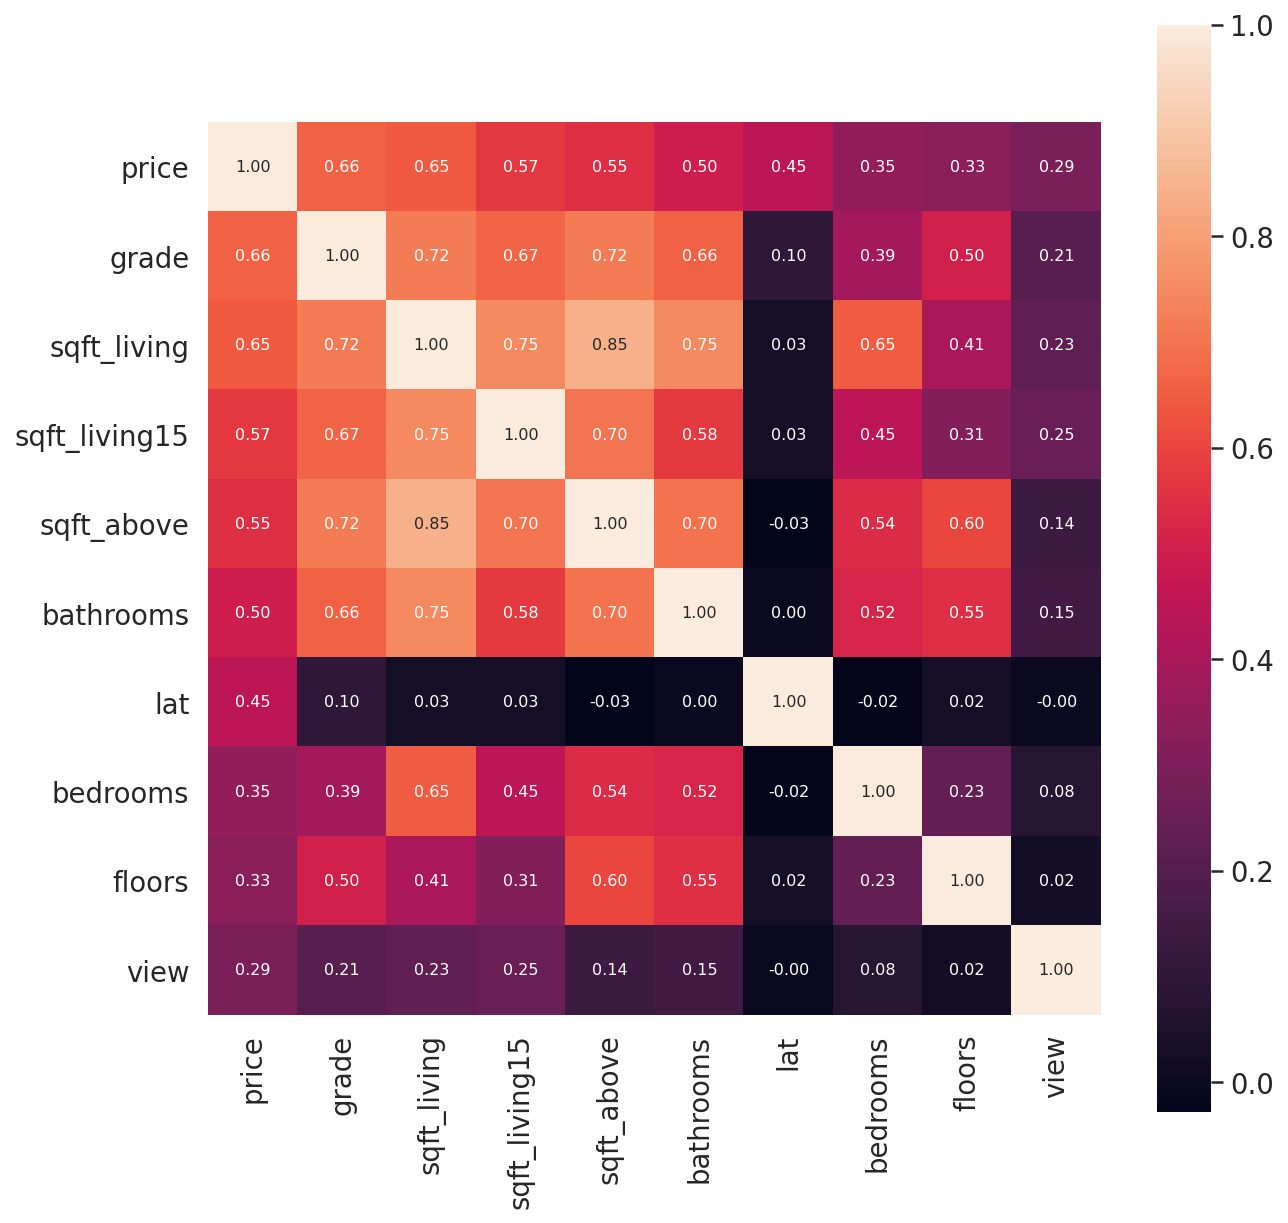

In [6]:
# 스피어만 순위 상관관계(연속형과 범주형 데이터가 혼재되어 있을 경우 사용)
cor_abs = abs(data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # 가격과 상관관계가 높은 column 10개
cor = np.array(sp.stats.spearmanr(data[cor_cols].values))[0] # 10 x 10

plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8},
            xticklabels=cor_cols.values, yticklabels=cor_cols.values)

### 1-5 주요 변수 시각화

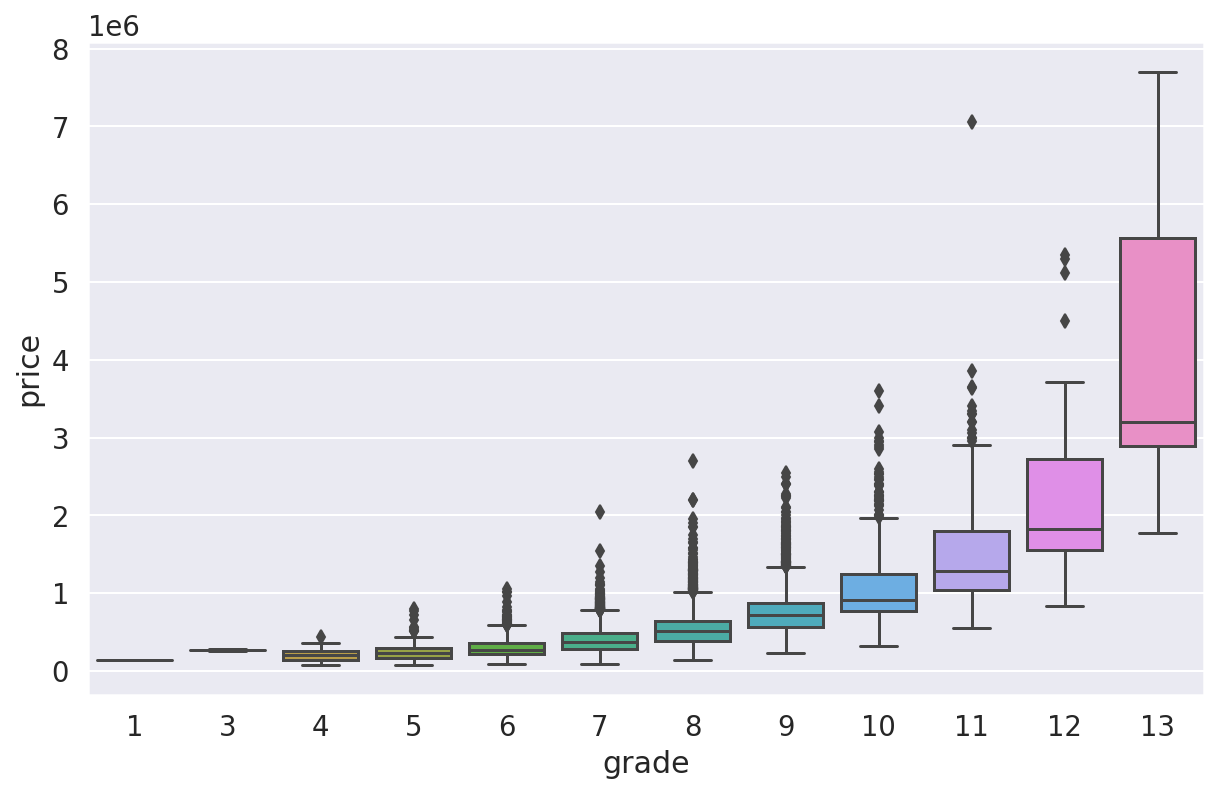

In [7]:
# grade 시각화
data_grade = pd.concat([data['price'], data['grade']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

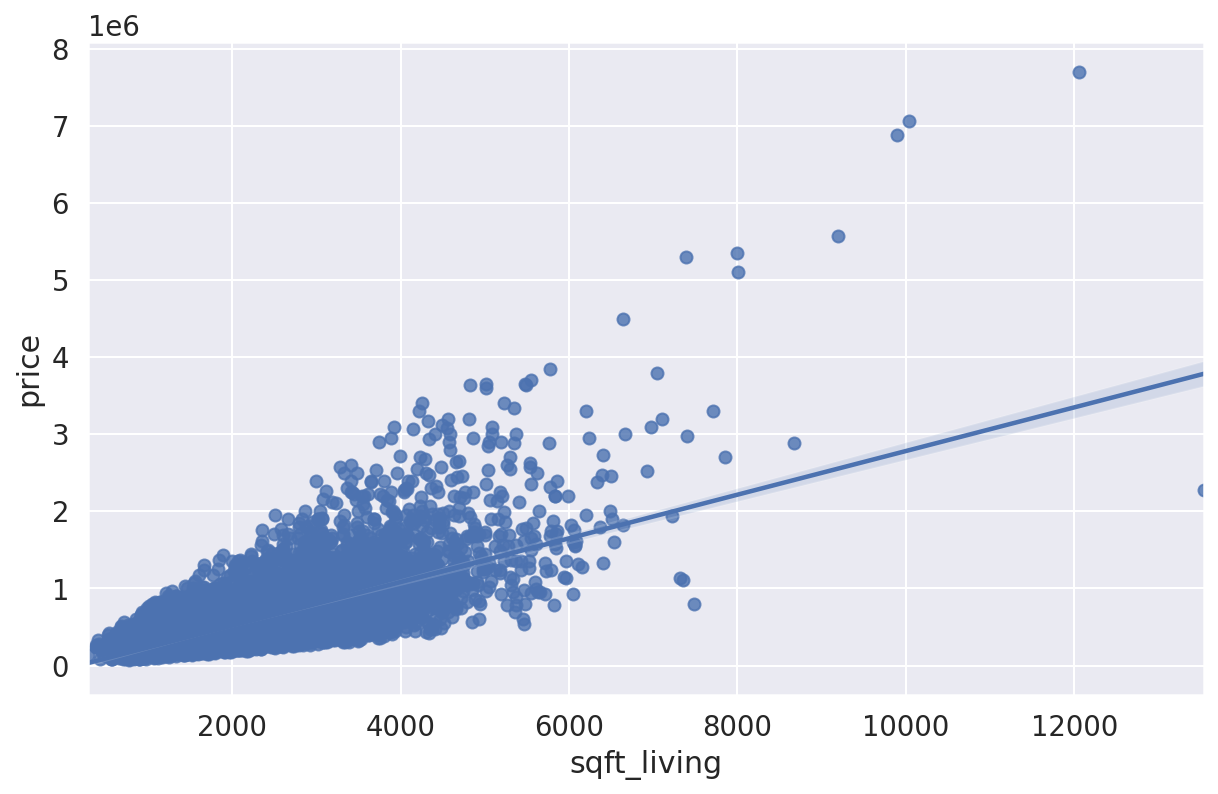

In [8]:
# sqft_living 시각화
data_sqft_living = pd.concat([data['price'], data['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

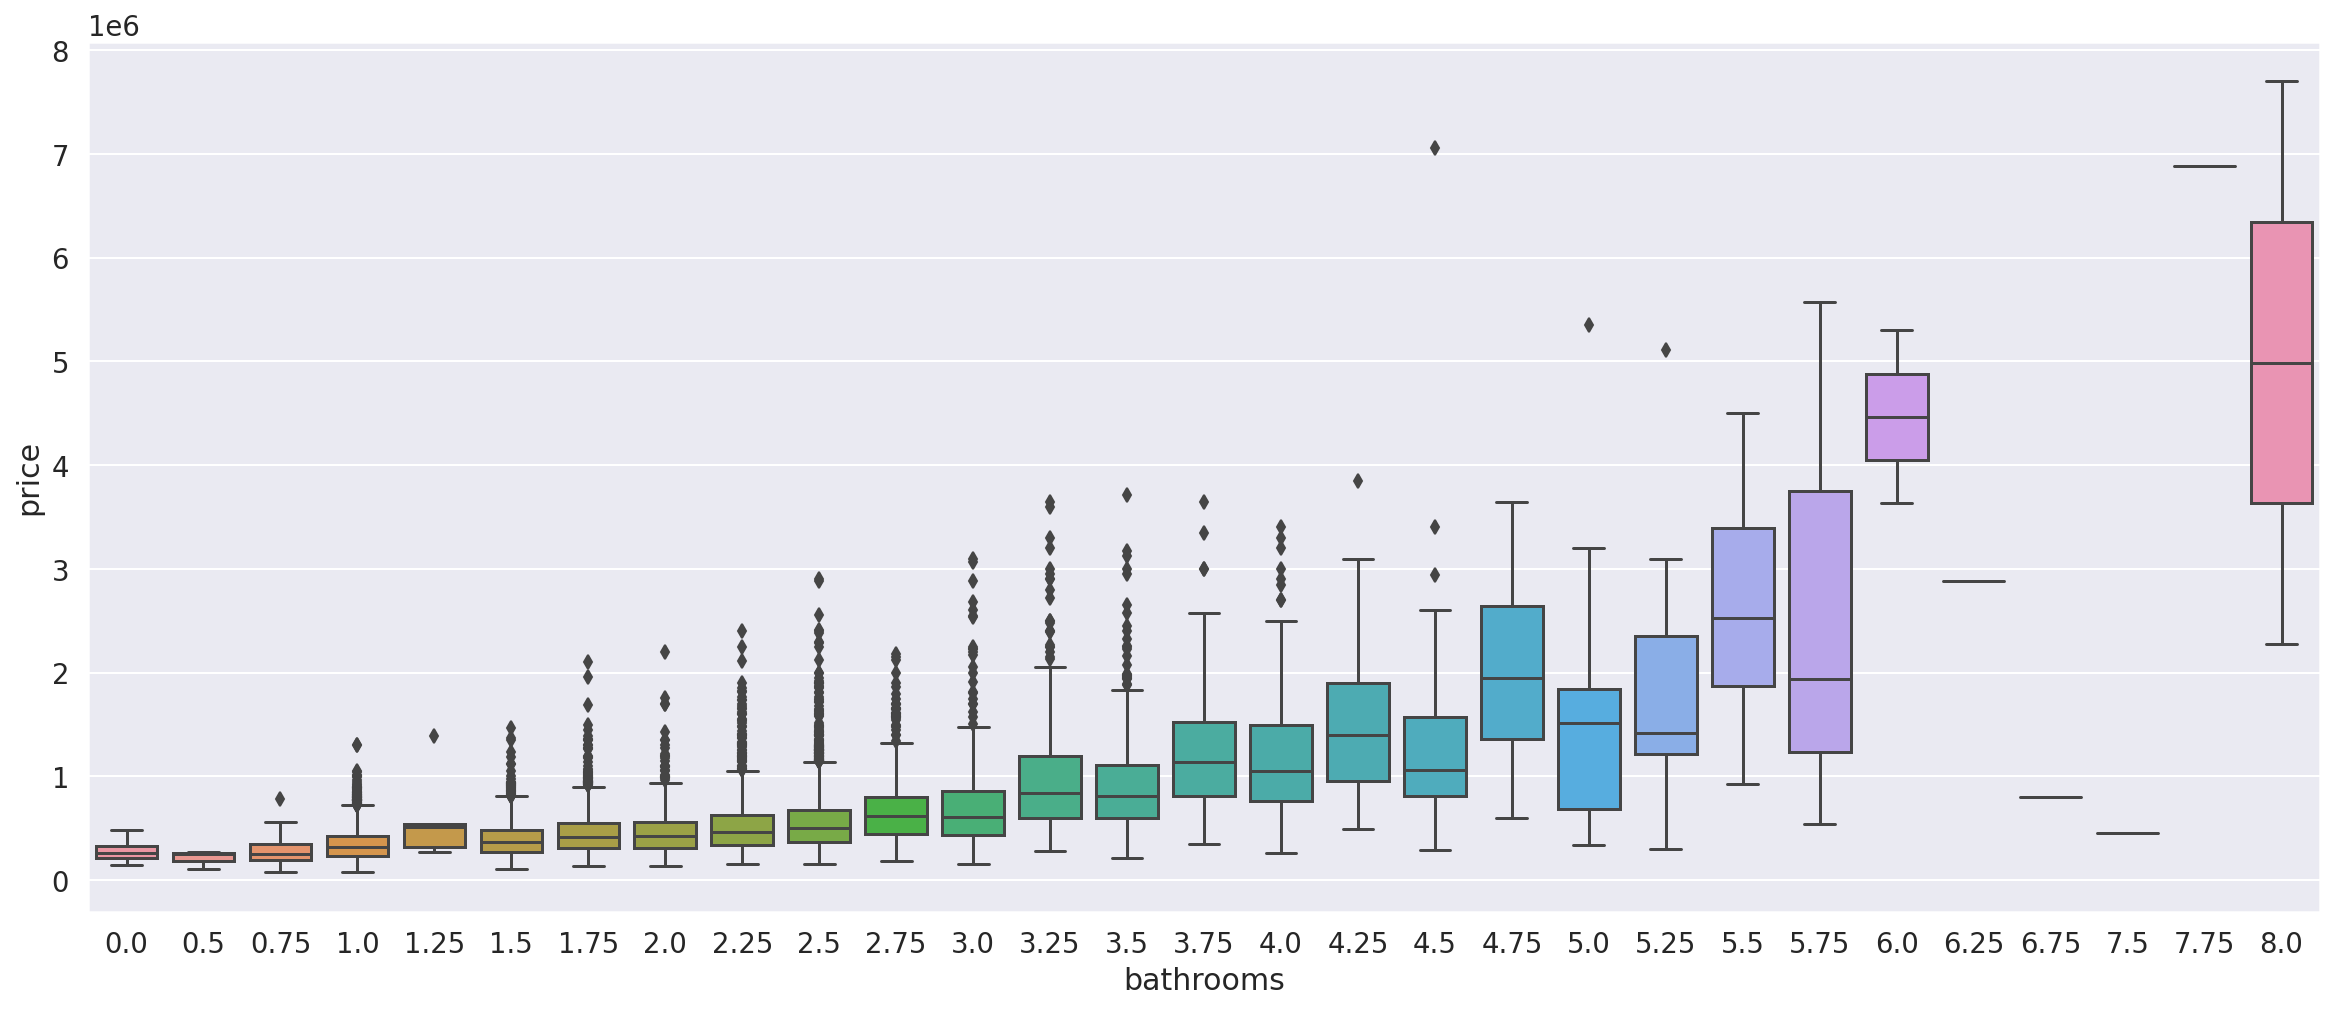

In [9]:
#bathrooms 시각화
data_bathrooms = pd.concat([data['price'], data['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(20, 8))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

---

## 2. 데이터 전처리 
- 훈련 데이터 목적변수 분리   
- 훈련 데이터와 평가 데이터 합치기   
- 결측치 확인, 이상치 확인, 정규화

In [10]:
# 훈련데이터에서 목적변수 분리
y = data['price']

del data['price']

In [11]:
# 훈련 데이터 평가 데이터 합치기 데이터 전처리 준비
train_len = len(data) # 추후 평가데이터 분리할때 필요. 책갈피

data = pd.concat((data, sub), axis=0)

In [12]:
# id 값 제거, date 값 수정
sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:8])).astype(int)

### 2-1 결측치 확인
msno.matrix(), msno.bar(), msno.heatmap(), msno.dendrogram() 사용 가능

<AxesSubplot:>

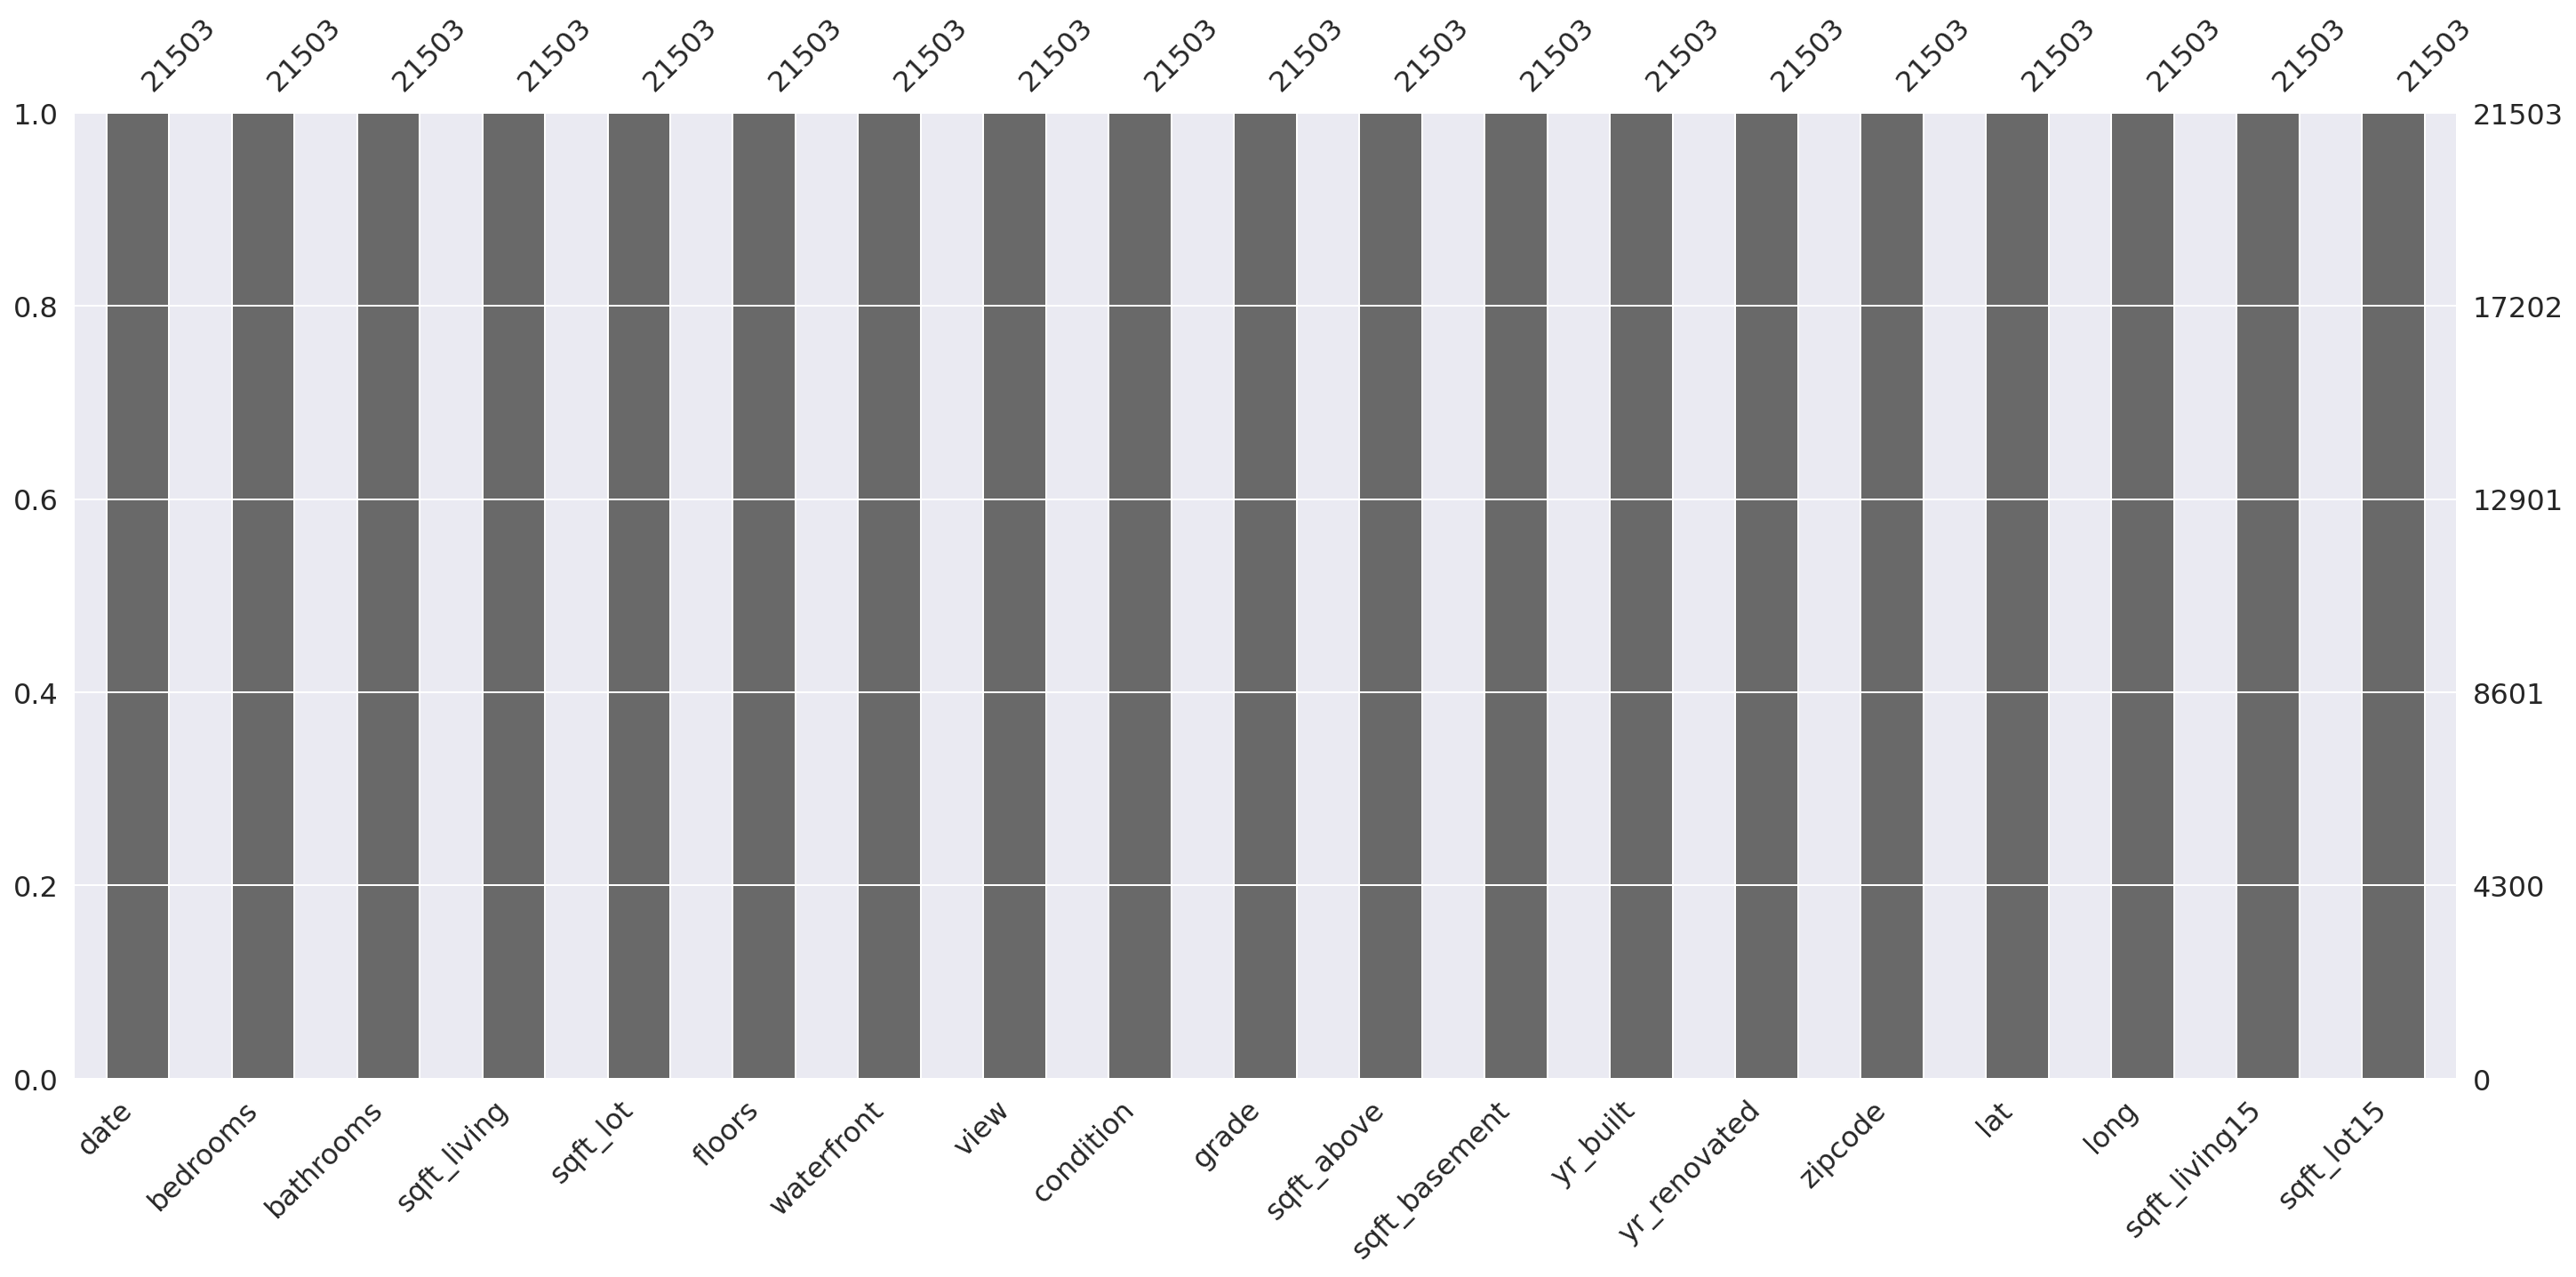

In [13]:
# 결측치 확인
msno.bar(data)

In [14]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### 2-2 이상치 확인
앞서 grade, sqft_living, bathrooms 그래프에서 이상치로 보이는 값을 확인하였지만 이번 노드에서는 하이퍼 파라미터 튜닝에 집중해서 모델의 성능을 최대한 끌어올려볼 예정으로 이상치를 제거하지 않음

### 2-3 정규화
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 정규화

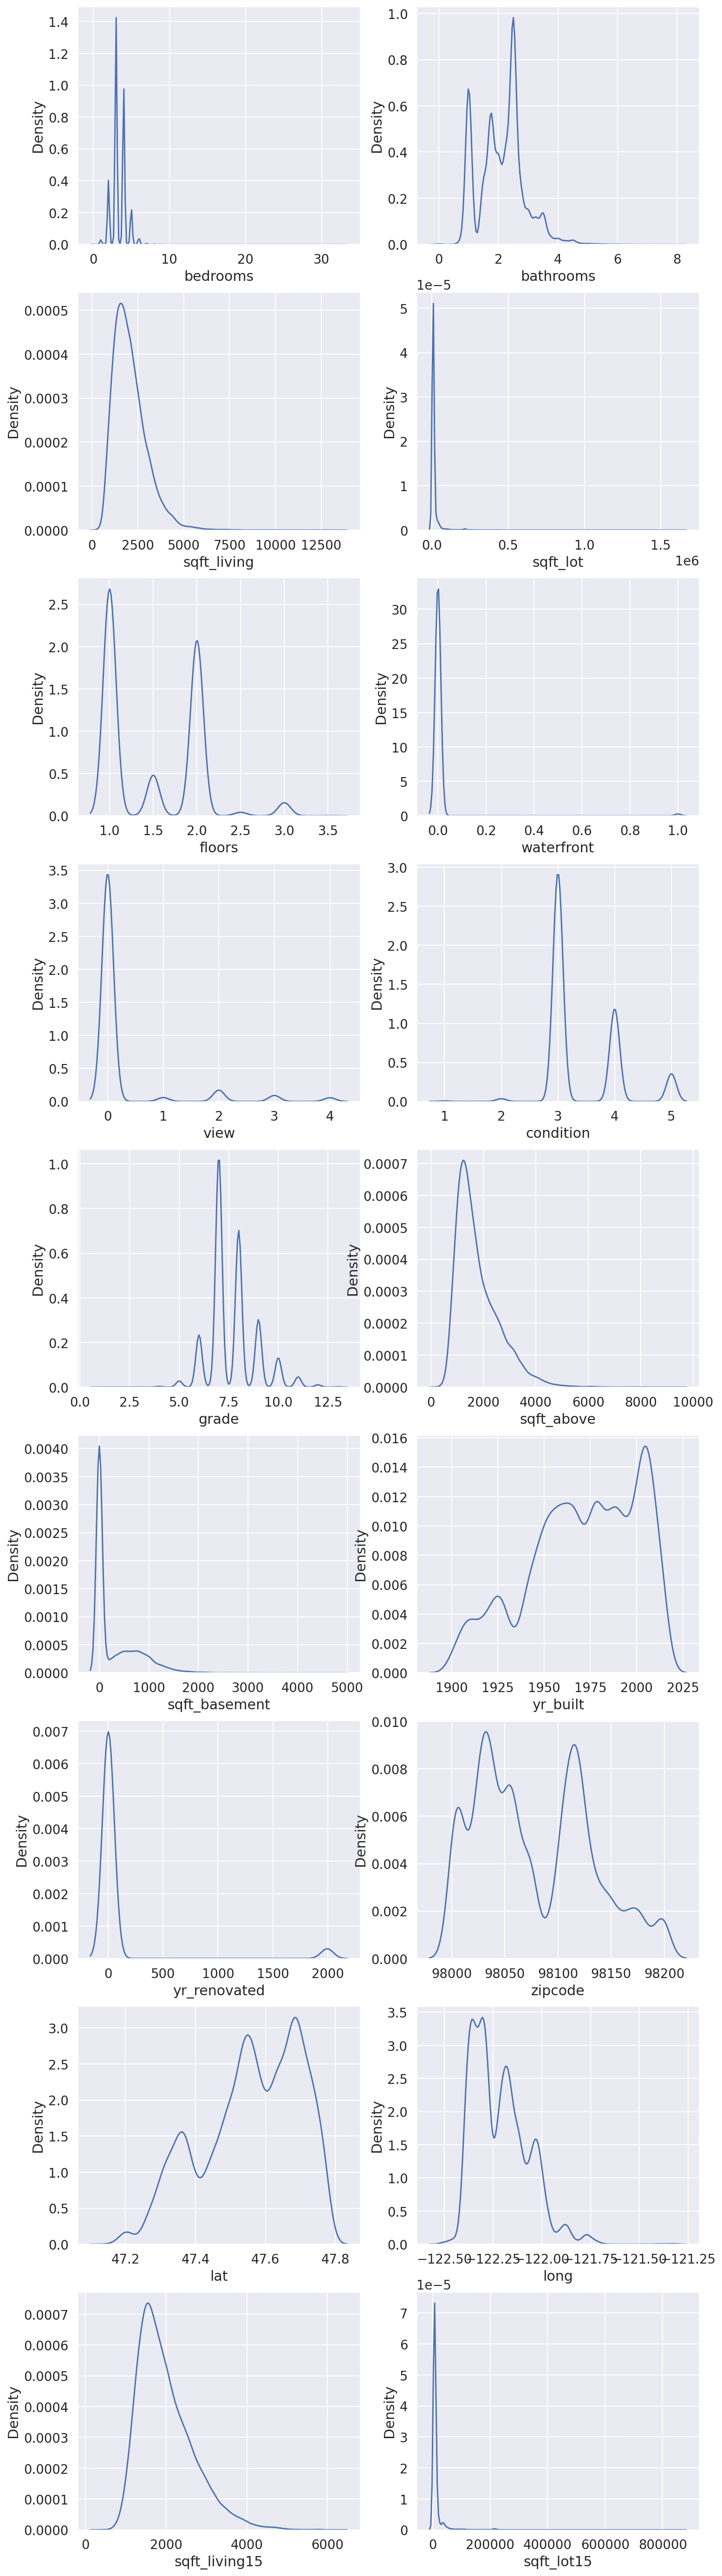

In [15]:
# 데이터의 변수 별 데이터 분포 시각화
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

count = 1
columns = data.columns
for row in range(9):
    for col in range(2): # bedrooms부터 sqft_lot15까지 확인
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        count += 1
        if count == 19 :
            break

In [16]:
# 정규화가 필요한 데이터를 선별해 정규화(좌측으로 치우친 형태)
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

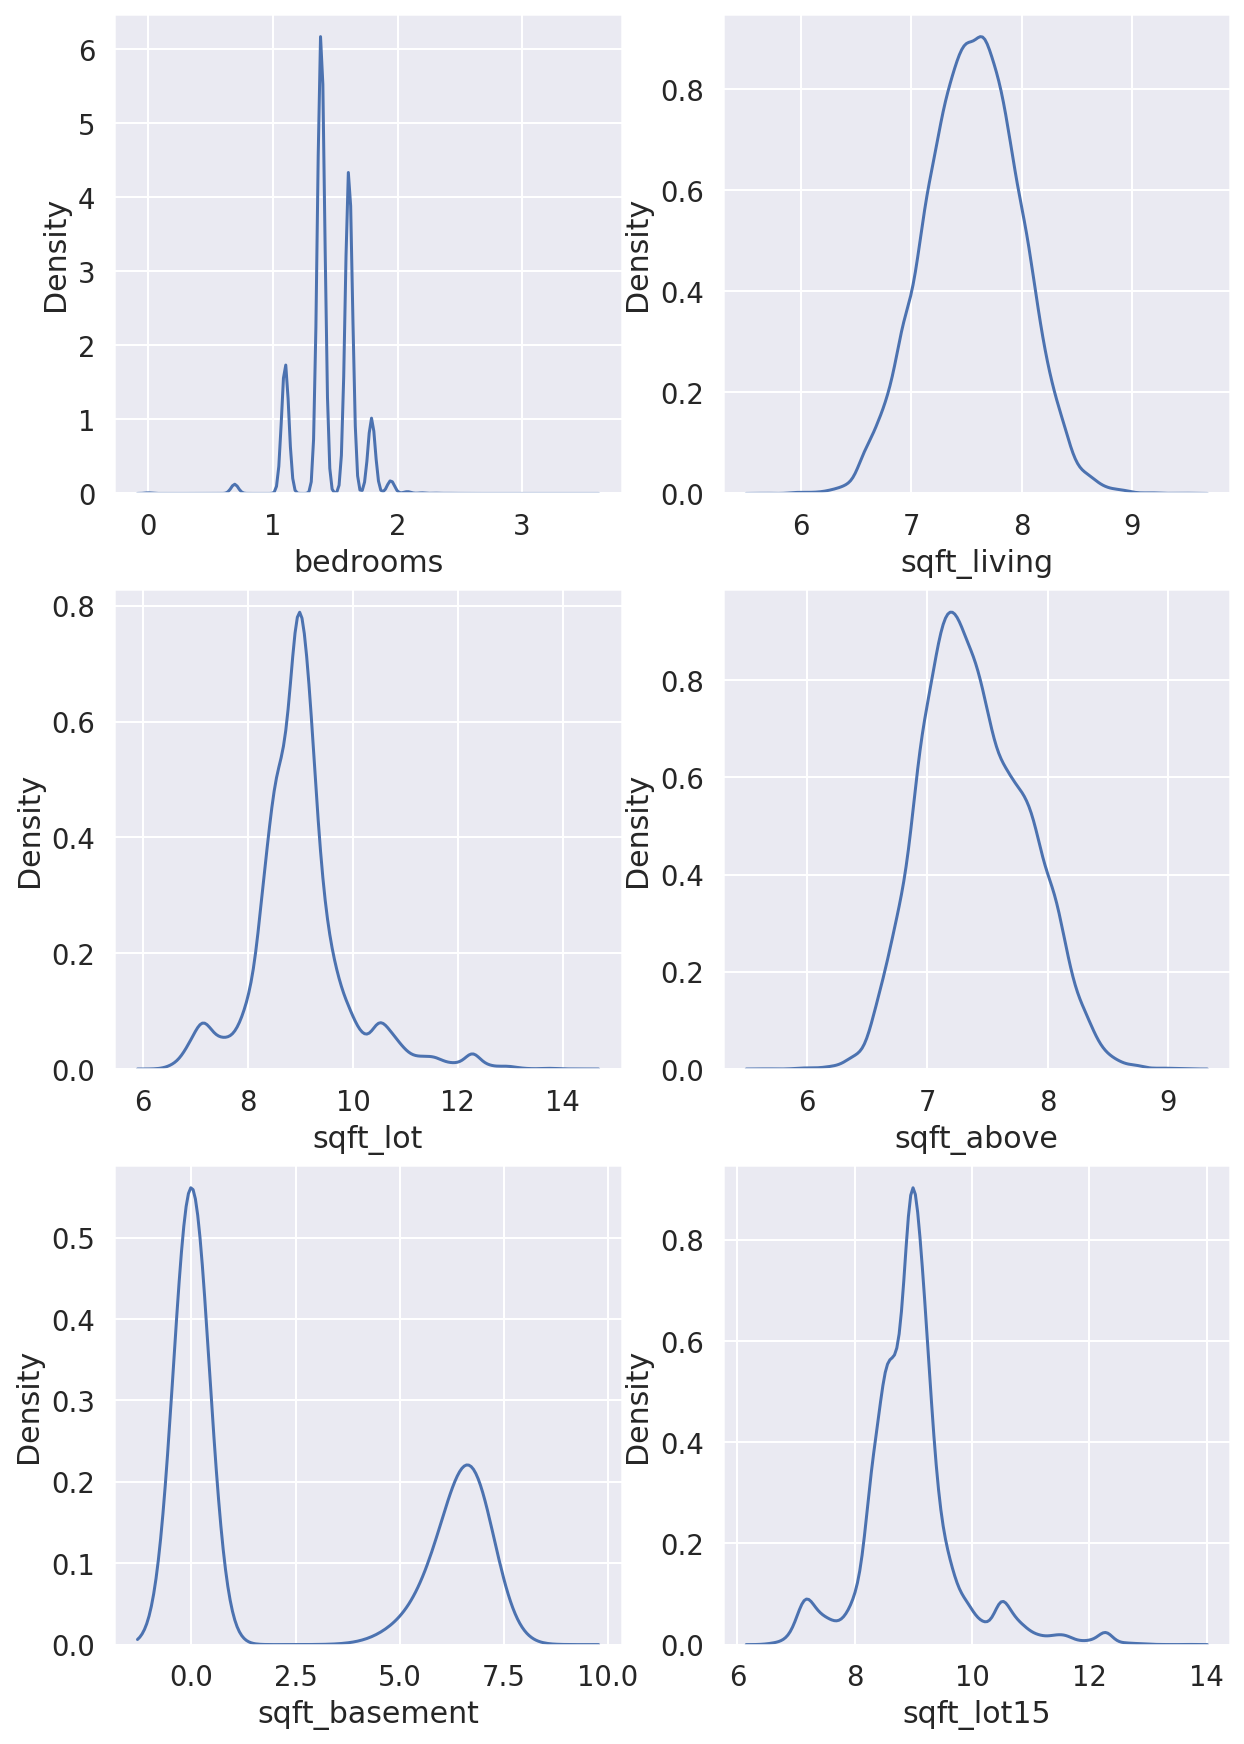

In [17]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 6:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        count+=1

In [18]:
# 전처리를 위해 합쳤던 훈련데이터, 테스트데이터 분리
train = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]
print(train.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


In [19]:
# 미리 분리한 목표변수 또한 정규화 필요(np.log1p()). 추후 np.exp1m()으로 되돌림 
y = np.log1p(y)

---

In [20]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,8.639588
1,20150225,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8.995041
2,20150218,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,8.923191
3,20140627,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,8.827615
4,20150115,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9.181118


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

## 3. 하이퍼파라미터 튜닝
### 3-1 그리드 서치
1. GridSearchCV로 모델을 초기화
2. 모델 fitting
3. params, score에 각 조합에 대한 결과를 저장 
4. 데이터 프레임을 생성, RMSLE 값을 추가.
5. 점수 내림차순 정렬 결과 반환

In [22]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [23]:
# LGBMRegressor
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [10, 20, 30],
    'learning_rate': [0.05],
    'num_iterations' : [1000]
}

model = LGBMRegressor(random_state=2021)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:   21.1s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
2,0.05,20,500,1000,-0.026062,0.161437
3,0.05,20,1000,1000,-0.026062,0.161437
4,0.05,30,500,1000,-0.026077,0.161484
5,0.05,30,1000,1000,-0.026077,0.161484
0,0.05,10,500,1000,-0.026160,0.161742
1,0.05,10,1000,1000,-0.026160,0.161742


In [24]:
# GradientBoostingRegressor
param_grid = {
    'learning_rate': [0.1],
    'n_estimators':[100,500],
    'max_depth': [10, 20, 30]
}

model = GradientBoostingRegressor(random_state=2021)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  30 out of  30 | elapsed:  5.0min finished


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,10,100,-0.029660,0.172220
1,0.1,10,500,-0.029738,0.172448
2,0.1,20,100,-0.052056,0.228157
3,0.1,20,500,-0.052056,0.228157
4,0.1,30,100,-0.060000,0.244949
5,0.1,30,500,-0.060001,0.244952


In [25]:
# XGBRegressor
param_grid = {
    'learning_rate': [0.1],
    'n_estimators':[10, 50],
    'max_depth': [5, 10]
}

model = XGBRegressor(random_state=2021)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


KeyboardInterrupt: 

## 4. 모델링
- 'n_estimators': 500
- 'max_depth': 20
- 'learning_rate': 0.05
- 'num_iterations' : 1000
- RMSLE: 0.161437

In [29]:
best = LGBMRegressor(random_state=2021,learning_rate = 0.05, n_estimators = 500, max_depth = 20, num_iterations = 1000)

In [30]:
def save_submission(model, train, y, sub, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(sub)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/aiffel_exploration/E6/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [31]:
save_submission(best, train, y, sub, 'LightGBM', rmsle='0.161')

/aiffel/aiffel/aiffel_exploration/E6/data/submission_LightGBM_RMSLE_0.161.csv saved!


## 5. 회고

- LightGBM의 경우 매우 빨라 여러번 시도하였으나 Gradient Boosting과 XGBoost는 시간이 너무 오래 걸렸다. 마지막으로 몇번 더 하이퍼파라미터를 수정하여 실험하다가 마감시간이 다되어 중지했다. 마감시간을 생각하며 실험을 진행해야겠다.

- 아쉽게도 목표치에 살짝 못미치는 점수를 얻었다. 하지만 일부러 이상치도 처리하지 않고 하이퍼파라미터만을 조절해서 점수를 올렸기 때문에 공부가 많이 된 것 같아서 좋습니다.


